In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from gensim.models import Word2Vec

from keras.callbacks import EarlyStopping

2023-05-13 09:17:01.276364: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-13 09:17:02.711886: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-13 09:17:08.843364: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-13 09:17:08.861378: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-13 09:17:51.839505: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

## Load Data

In [2]:
# Load data, read tokenized_tweet, stemmed_tweet, and no_stopwords_tweet as a list
df = pd.read_pickle('data/preprocessed_data.pkl')

In [3]:
# Remove Neutral tweets
df = df[df['sentiment'] != 'Neutral']
df.shape

(5235, 10)

## Train and Test Split

In [8]:
# Train Test Split Function
def split_train_test(df, test_size=0.3, shuffle_state=True):
    X_train, X_test, Y_train, Y_test = train_test_split(df[['vaccine', 'no_stopwords_tweet']], 
                                                        df['sentiment'], 
                                                        shuffle=shuffle_state,
                                                        test_size=test_size, 
                                                        random_state=15,
                                                        stratify=df['sentiment'])
    print("Value counts for Train sentiments")
    print(Y_train.value_counts())
    
    print("Value counts for Test sentiments")
    print(Y_test.value_counts())
    print(type(X_train))
    print(type(Y_train))
    X_train = X_train.reset_index()
    X_test = X_test.reset_index()
    Y_train = Y_train.to_frame()
    Y_train = Y_train.reset_index()
    Y_test = Y_test.to_frame()
    Y_test = Y_test.reset_index()
    print(X_train.head())
    return X_train, X_test, Y_train, Y_test

# Call the train_test_split
X_train, X_test, Y_train, Y_test = split_train_test(df)

Value counts for Train sentiments
sentiment
Negative    1968
Positive    1696
Name: count, dtype: int64
Value counts for Test sentiments
sentiment
Negative    844
Positive    727
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>
   index         vaccine                                 no_stopwords_tweet
0   5138         moderna  [moderna, dose, today, yey, avip, gotyourvacc,...
1   1951  Not Applicable  [naman, po, ata, discrimination, management, p...
2   8444          Pfizer  [pfizer, transparent, results, vaccine, studie...
3   8472          Pfizer        [mas, tiwala, tawa, pfizer, sinovac, china]
4    802         Sinovac  [sinovac, manufacturing, vaccines, polio, hepa...


In [10]:
X_test.shape, Y_test.shape

((1571, 3), (1571, 2))

In [13]:
# Create X_val and Y_val from X_test and Y_test
X_test, X_val, Y_test, Y_val = train_test_split(X_test[['vaccine', 'no_stopwords_tweet']],
                                                Y_test['sentiment'],
                                                shuffle=True,
                                                test_size=0.333,
                                                random_state=15,
                                                stratify=Y_test['sentiment'])

In [14]:
X_train.shape, X_test.shape, X_val.shape, Y_train.shape, Y_test.shape, Y_val.shape

((3664, 3), (1047, 2), (524, 2), (3664, 2), (1047,), (524,))

## Generate word2vec model

[Github Link](https://github.com/danjohnvelasco/Filipino-Word-Embeddings)

In [15]:
from gensim.models import Word2Vec

size_dim = 300 # Default number of dimensions of the embeddings. So no need to add separatley

w2v_model = Word2Vec.load('word2vec/word2vec_300dim_20epochs.model')

In [16]:
# Add new vocabulary to w2v_model
w2v_model.build_vocab(X_train['no_stopwords_tweet'], update=True)

# Train the Word2Vec Model
w2v_model.train(X_train['no_stopwords_tweet'], total_examples=w2v_model.corpus_count, epochs=50)

(2059461, 2609250)

## Feature Extraction

In [23]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train.no_stopwords_tweet)
X_train_seq = tokenizer.texts_to_sequences(X_train.no_stopwords_tweet)
X_val_seq = tokenizer.texts_to_sequences(X_val.no_stopwords_tweet)
X_test_seq = tokenizer.texts_to_sequences(X_test.no_stopwords_tweet)

In [24]:
from keras.utils import pad_sequences

max_seq_len = 50 # Define the maximum length of the sequence
X_train_seq = pad_sequences(X_train_seq, maxlen=max_seq_len, padding='post', truncating='post')
X_val_seq = pad_sequences(X_val_seq, maxlen=max_seq_len, padding='post', truncating='post')
X_test_seq = pad_sequences(X_test_seq, maxlen=max_seq_len, padding='post', truncating='post')

In [25]:
embedding_dim = size_dim # Define the embedding dimension
vocab_size = len(tokenizer.word_index) + 1

# Create a weight matrix for words in training docs
embedding_matrix = np.zeros((vocab_size, size_dim))
for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]

In [35]:
# to categorical y_train and y_test
from keras.utils import to_categorical

y_train = Y_train['sentiment'].map({'Negative': 0, 'Positive': 1})
y_val = Y_val.map({'Negative': 0, 'Positive': 1})
y_test = Y_test.map({'Negative': 0, 'Positive': 1})

In [36]:
y_train.shape, y_test.shape, y_val.shape

((3664,), (1047,), (524,))

## Model Training

### Build and Train LSTM Model

In [37]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding, Dropout
from keras.callbacks import EarlyStopping

# Define the model architecture
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_seq_len, trainable=True))
model.add(LSTM(units=128, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(units=128, dropout=0.2, recurrent_dropout=0.2))

# Output layer for binary classification
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 300)           3324600   
                                                                 
 lstm (LSTM)                 (None, 50, 128)           219648    
                                                                 
 dropout (Dropout)           (None, 50, 128)           0         
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 3,675,961
Trainable params: 3,675,961
Non-trainable params: 0
_________________________________________________________________


In [38]:
# Add early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, mode='min')

In [39]:
# Fit the model to the training data
model.fit(X_train_seq, y_train, epochs=10, batch_size=32, validation_data=(X_val_seq, y_val), callbacks=[early_stopping])

Epoch 1/10
115/115 [==============================] - 37s 247ms/step - loss: 0.6307 - accuracy: 0.6482 - val_loss: 0.5254 - val_accuracy: 0.7405
Epoch 2/10
115/115 [==============================] - 26s 222ms/step - loss: 0.5582 - accuracy: 0.7328 - val_loss: 0.5312 - val_accuracy: 0.7615
Epoch 3/10
115/115 [==============================] - 25s 215ms/step - loss: 0.4775 - accuracy: 0.7939 - val_loss: 0.5010 - val_accuracy: 0.7462
Epoch 4/10
115/115 [==============================] - 29s 252ms/step - loss: 0.4230 - accuracy: 0.8226 - val_loss: 0.4948 - val_accuracy: 0.7615
Epoch 5/10
115/115 [==============================] - 25s 218ms/step - loss: 0.3633 - accuracy: 0.8608 - val_loss: 0.5142 - val_accuracy: 0.7405
Epoch 6/10
115/115 [==============================] - 25s 219ms/step - loss: 0.3322 - accuracy: 0.8766 - val_loss: 0.5730 - val_accuracy: 0.7519
Epoch 7/10
115/115 [==============================] - 27s 238ms/step - loss: 0.2695 - accuracy: 0.9031 - val_loss: 0.5762 - val_ac

In [40]:
# Test model
test_loss, test_acc = model.evaluate(X_test_seq, y_test)
print('Test accuracy:', test_acc)

33/33 [==============================] - 1s 42ms/step - loss: 0.5975 - accuracy: 0.7612
Test accuracy: 0.7612225413322449


In [41]:
# model evaluation: classification report and confusion matrix

# Print classification report for binary classification
y_pred = model.predict(X_test_seq)
y_pred = np.round(y_pred).astype(int)
print(classification_report(y_test, y_pred))

33/33 [==============================] - 2s 52ms/step
              precision    recall  f1-score   support

           0       0.75      0.83      0.79       562
           1       0.78      0.68      0.72       485

    accuracy                           0.76      1047
   macro avg       0.76      0.76      0.76      1047
weighted avg       0.76      0.76      0.76      1047



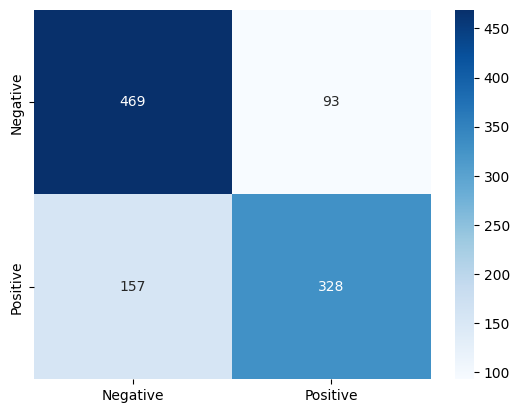

In [42]:
# plot confusion matrix
import seaborn as sns

# Confusion matrix for binary classification, rename the classes accordingly
cm = confusion_matrix(y_test, y_pred)
cm = pd.DataFrame(cm, index=['Negative', 'Positive'], columns=['Negative', 'Positive'])
# Make it into percentage
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues');

In [43]:
cm

,Negative,Positive
Negative,469,93
Positive,157,328


## Build and Train Bidirectional LSTM model

In [44]:
from tensorflow.keras.layers import Bidirectional

# Define the model architecture
model_bilstm = Sequential()
model_bilstm.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_seq_len, trainable=True))
model_bilstm.add(Bidirectional(LSTM(units=128, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)))
model_bilstm.add(Dropout(0.3))
model_bilstm.add(Bidirectional(LSTM(units=64, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)))
model_bilstm.add(Dropout(0.3))
model_bilstm.add(Bidirectional(LSTM(units=32, dropout=0.2, recurrent_dropout=0.2)))
model_bilstm.add(Dropout(0.3))

# Output layer for binary classification
model_bilstm.add(Dense(1, activation='sigmoid'))

# Compile the model
model_bilstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model_bilstm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 50, 300)           3324600   
                                                                 
 bidirectional (Bidirectiona  (None, 50, 256)          439296    
 l)                                                              
                                                                 
 dropout_1 (Dropout)         (None, 50, 256)           0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 50, 128)          164352    
 nal)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 50, 128)           0         
                                                                 
 bidirectional_2 (Bidirectio  (None, 64)              

In [45]:
# Fit the model to the training data
model_bilstm.fit(X_train_seq, y_train, epochs=10, batch_size=32, validation_data=(X_val_seq, y_val), callbacks=[early_stopping])

Epoch 1/10
115/115 [==============================] - 67s 414ms/step - loss: 0.5583 - accuracy: 0.7115 - val_loss: 0.4918 - val_accuracy: 0.7424
Epoch 2/10
115/115 [==============================] - 42s 366ms/step - loss: 0.4462 - accuracy: 0.7975 - val_loss: 0.4639 - val_accuracy: 0.7729
Epoch 3/10
115/115 [==============================] - 42s 363ms/step - loss: 0.3510 - accuracy: 0.8447 - val_loss: 0.4989 - val_accuracy: 0.7615
Epoch 4/10
115/115 [==============================] - 46s 403ms/step - loss: 0.2439 - accuracy: 0.9094 - val_loss: 0.5956 - val_accuracy: 0.7576
Epoch 5/10
115/115 [==============================] - 43s 372ms/step - loss: 0.1690 - accuracy: 0.9405 - val_loss: 0.6744 - val_accuracy: 0.7557


In [46]:
# Test model
test_loss, test_acc = model_bilstm.evaluate(X_test_seq, y_test)
print('Test accuracy:', test_acc)

33/33 [==============================] - 2s 55ms/step - loss: 0.6801 - accuracy: 0.7622
Test accuracy: 0.7621776461601257


In [47]:
# Print classification report for binary classification
y_pred = model_bilstm.predict(X_test_seq)
y_pred = np.round(y_pred).astype(int)
print(classification_report(y_test, y_pred))

33/33 [==============================] - 3s 59ms/step
              precision    recall  f1-score   support

           0       0.78      0.78      0.78       562
           1       0.74      0.74      0.74       485

    accuracy                           0.76      1047
   macro avg       0.76      0.76      0.76      1047
weighted avg       0.76      0.76      0.76      1047



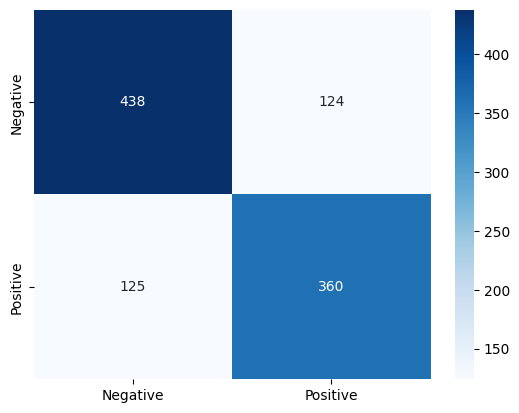

In [48]:
# plot confusion matrix+
# Confusion matrix for binary classification, rename the classes accordingly
cm = confusion_matrix(y_test, y_pred)
cm = pd.DataFrame(cm, index=['Negative', 'Positive'], columns=['Negative', 'Positive'])
# Make it into percentage
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues');

### Build and Train CNN + LSTM Model

11082

In [57]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Embedding, LSTM, Conv1D, MaxPooling1D, Flatten
from keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

# Define hyperparameters
max_features = embedding_matrix.shape[0]  # Maximum number of words in the vocabulary
max_seq_len = 50  # Maximum length of input sequences
embedding_dim = 300  # Size of word embeddings
num_filters = 80  # Number of filters in each convolutional layer
filter_sizes = [1, 2, 3]  # Sizes of filters in each convolutional layer
lstm_units = 128  # Number of LSTM units
dropout_rate = 0.3  # Dropout rate
l2_coef = 0.1  # L2 regularization coefficient
batch_size = 32  # Batch size
epochs = 10  # Number of epochs

# Define the model architecture
model_cnn_lstm = Sequential()
model_cnn_lstm.add(Embedding(input_dim=max_features, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_seq_len, trainable=True))
model_cnn_lstm.add(Dropout(dropout_rate))
model_cnn_lstm.add(Conv1D(num_filters, filter_sizes[0], padding='valid', activation='relu', strides=1))
model_cnn_lstm.add(Conv1D(num_filters, filter_sizes[1], padding='valid', activation='relu', strides=1))
model_cnn_lstm.add(Conv1D(num_filters, filter_sizes[2], padding='valid', activation='relu', strides=1))
model_cnn_lstm.add(MaxPooling1D(pool_size=2))
model_cnn_lstm.add(LSTM(lstm_units, return_sequences=True))
model_cnn_lstm.add(Flatten())
model_cnn_lstm.add(Dense(num_filters, activation='relu', kernel_regularizer=l2(l2_coef)))
model_cnn_lstm.add(Dropout(dropout_rate))

# Output layer for binary classification
model_cnn_lstm.add(Dense(1, activation='sigmoid'))

# Compile the model
optimizer = Adam()
model_cnn_lstm.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

model_cnn_lstm.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 50, 300)           3324600   
                                                                 
 dropout_4 (Dropout)         (None, 50, 300)           0         
                                                                 
 conv1d (Conv1D)             (None, 50, 80)            24080     
                                                                 
 conv1d_1 (Conv1D)           (None, 49, 80)            12880     
                                                                 
 conv1d_2 (Conv1D)           (None, 47, 80)            19280     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 23, 80)           0         
 )                                                               
                                                      

2023-05-13 10:06:08.331336: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-13 10:06:08.354031: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-13 10:06:08.361265: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

                                                                 
 dense_2 (Dense)             (None, 80)                235600    
                                                                 
 dropout_5 (Dropout)         (None, 80)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 81        
                                                                 
Total params: 3,723,529
Trainable params: 3,723,529
Non-trainable params: 0
_________________________________________________________________


In [60]:
# Add early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, mode='min')

# Train model

model_cnn_lstm.fit(X_train_seq, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val_seq, y_val), callbacks=[early_stopping])

Epoch 1/10
115/115 [==============================] - 7s 61ms/step - loss: 0.2137 - accuracy: 0.9410 - val_loss: 0.6918 - val_accuracy: 0.7519
Epoch 2/10
115/115 [==============================] - 7s 58ms/step - loss: 0.1655 - accuracy: 0.9536 - val_loss: 0.7867 - val_accuracy: 0.7462
Epoch 3/10
115/115 [==============================] - 7s 60ms/step - loss: 0.1246 - accuracy: 0.9653 - val_loss: 0.6767 - val_accuracy: 0.7576
Epoch 4/10
115/115 [==============================] - 7s 59ms/step - loss: 0.1344 - accuracy: 0.9692 - val_loss: 0.7925 - val_accuracy: 0.7424
Epoch 5/10
115/115 [==============================] - 7s 60ms/step - loss: 0.1028 - accuracy: 0.9738 - val_loss: 0.9748 - val_accuracy: 0.7462
Epoch 6/10
115/115 [==============================] - 7s 59ms/step - loss: 0.1073 - accuracy: 0.9708 - val_loss: 0.9004 - val_accuracy: 0.7366


In [61]:
# Test model
test_loss, test_acc = model_cnn_lstm.evaluate(X_test_seq, y_test)
print('Test accuracy:', test_acc)

33/33 [==============================] - 0s 12ms/step - loss: 0.9406 - accuracy: 0.7307
Test accuracy: 0.730659008026123


In [62]:
# Print classification report for binary classification
y_pred = model_cnn_lstm.predict(X_test_seq)
y_pred = np.where(y_pred > 0.5, 1, 0)
print(classification_report(y_test, y_pred))

 1/33 [..............................] - ETA: 15s

2023-05-13 10:08:36.062625: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-13 10:08:36.064381: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-13 10:08:36.065798: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

33/33 [==============================] - 1s 15ms/step
              precision    recall  f1-score   support

           0       0.74      0.76      0.75       562
           1       0.72      0.69      0.70       485

    accuracy                           0.73      1047
   macro avg       0.73      0.73      0.73      1047
weighted avg       0.73      0.73      0.73      1047



<Axes: >

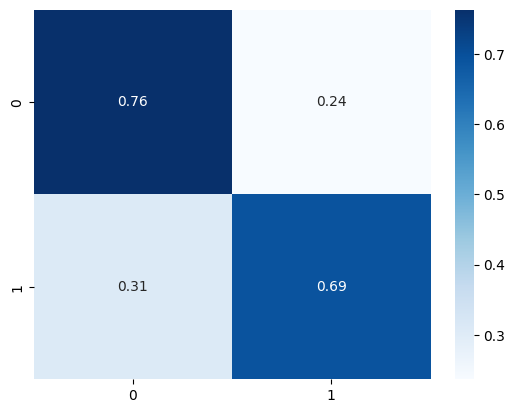

In [63]:
# plot confusion matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm, annot=True, cmap='Blues')

## Build and Train CNN Model

In [64]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, Conv1D, GlobalMaxPooling1D, Dropout
from keras.optimizers import Adamax
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
from sklearn.utils import class_weight

# Create CNN model
model_cnn = Sequential()

# Add trainable embedding layer
model_cnn.add(Embedding(input_dim=max_features, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_seq_len, trainable=True))

# Add two convolutional layers with increasing filters and kernel sizes
model_cnn.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
model_cnn.add(Conv1D(filters=64, kernel_size=5, activation='relu'))

# Add global max pooling layer
model_cnn.add(GlobalMaxPooling1D())

# Add two dense layers with ReLU activation and L2 regularization
model_cnn.add(Dense(units=128, activation='relu', kernel_regularizer=l2(0.01)))
model_cnn.add(Dense(units=64, activation='relu', kernel_regularizer=l2(0.01)))

# Add dropout layer with a rate of 0.5
model_cnn.add(Dropout(0.5))

# Add output layer with 3 units and softmax activation for multi-class classification
model_cnn.add(Dense(units=1, activation='sigmoid'))

# Compile the model with categorical cross-entropy loss, Adamax optimizer and accuracy metric
optimizer = Adam(learning_rate=0.001)
model_cnn.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Define class weights for imbalanced dataset
# class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train))

model_cnn.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 50, 300)           3324600   
                                                                 
 conv1d_3 (Conv1D)           (None, 48, 32)            28832     
                                                                 
 conv1d_4 (Conv1D)           (None, 44, 64)            10304     
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_4 (Dense)             (None, 128)               8320      
                                                                 
 dense_5 (Dense)             (None, 64)                8256      
                                                      

In [65]:
# Train the model with class weights and early stopping
model_cnn.fit(X_train_seq, y_train, epochs=20, batch_size=32, validation_data=(X_val_seq, y_val), callbacks=[early_stopping])

Epoch 1/20
115/115 [==============================] - 6s 42ms/step - loss: 1.6788 - accuracy: 0.6487 - val_loss: 1.1219 - val_accuracy: 0.7405
Epoch 2/20
115/115 [==============================] - 4s 35ms/step - loss: 0.9239 - accuracy: 0.7576 - val_loss: 0.7782 - val_accuracy: 0.7557
Epoch 3/20
115/115 [==============================] - 4s 35ms/step - loss: 0.5937 - accuracy: 0.8515 - val_loss: 0.7034 - val_accuracy: 0.7634
Epoch 4/20
115/115 [==============================] - 4s 32ms/step - loss: 0.3629 - accuracy: 0.9315 - val_loss: 0.7805 - val_accuracy: 0.7328
Epoch 5/20
115/115 [==============================] - 4s 34ms/step - loss: 0.2376 - accuracy: 0.9623 - val_loss: 0.8727 - val_accuracy: 0.6908
Epoch 6/20
115/115 [==============================] - 4s 32ms/step - loss: 0.1761 - accuracy: 0.9765 - val_loss: 1.0274 - val_accuracy: 0.6870


In [66]:
# Test model
test_loss, test_acc = model_cnn.evaluate(X_test_seq, y_test)
print('Test accuracy:', test_acc)

33/33 [==============================] - 0s 5ms/step - loss: 1.1420 - accuracy: 0.6638
Test accuracy: 0.6638013124465942
